<a href="https://www.kaggle.com/code/rohit4468/pytorch-lenet-5-cifar?scriptVersionId=257372142" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar100/meta
/kaggle/input/cifar100/file.txt
/kaggle/input/cifar100/test
/kaggle/input/cifar100/train


In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision.datasets import CIFAR10
torch.__version__,torchvision.__version__

('2.6.0+cu124', '0.21.0+cu124')

This Code downloads the dataset in the kaggle working directory in datafolder

In [3]:
cifar10= CIFAR10(root='data', download=True)

100%|██████████| 170M/170M [00:03<00:00, 49.8MB/s] 


Device Agnoistic Code

In [4]:

device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Import and Download of the CIFAR10 dataset

1. **train_data**: Folder that contains the train datset
2. **test_data**: Folder that contains the test datset


In [5]:
from torchvision.datasets import CIFAR10
train_data=torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=ToTensor(), target_transform=None)
test_data=torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=ToTensor(), target_transform=None)

# Getting the Class Name

In [6]:
#class name as a list
class_name=train_data.classes

#class name as dict
class_name_dict=train_data.class_to_idx

class_name, class_name_dict

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 {'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9})

# Visualizing an image

Access the first image and label in train_data.

Since the image is represented as a tensor with shape: torch.Size([3, 32, 32]) (i.e., (C, H, W) where C stands for channels, H for height, and W for width), you need to adjust it because matplotlib expects images in the format (H, W, C) — a NumPy array with shape (height, width, channels).

To achieve this, you’ll need to transpose the image from (C, H, W) to (H, W, C) before displaying it using matplotlib.pyplot.imshow.

(-0.5, 31.5, 31.5, -0.5)

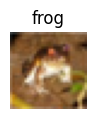

In [7]:
#Visualizing an image
image, label=train_data[0]
plt.figure(figsize=(1,1))
plt.imshow(image.permute(1,2,0))
plt.title(class_name[label])
plt.axis(False)

In [8]:
image.shape

torch.Size([3, 32, 32])

# Loading the datset using the DataLoader Function

In [9]:
from torch.utils.data import DataLoader
BATCH_SIZE=32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader  = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

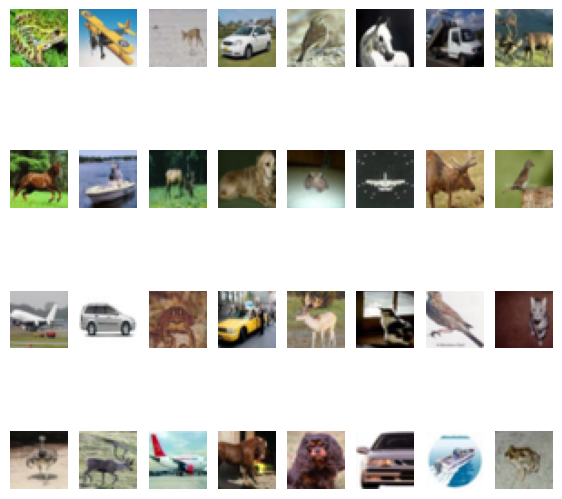

In [10]:
#visulisation of all the images of a batch
torch.manual_seed(42)
train_featues_batch, test_feature_batch= next(iter(train_dataloader))
fig=plt.figure(figsize=(7,7))
rows=4
cols=8
for i in range(BATCH_SIZE):
    img, label= train_featues_batch[i], test_feature_batch[i]
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(img.permute(1,2,0))
    plt.axis(False)

In [11]:
from torch import nn
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.layer1= nn.Sequential(
            #layer 1
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            #layer2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2))
        
        self.classifier=nn.Sequential(
            nn.Flatten(),
            #layer3
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            #layer4
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            #layer5
            nn.Linear(in_features=84, out_features=10))  #total no. of classes is 10 so out feature is 10

    def forward(self, x:torch.Tensor):
        x=self.layer1(x)
        x=self.classifier(x)
        return x

In [12]:
from torchsummary import summary
model=LeNet5().to(device)

In [13]:
#optimsiser and loss fun
LR=0.00009
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model.parameters(), lr=LR, momentum=0.9)

def acc_fn(predictions, labels):
    _, predicted_classes = torch.max(predictions, 1)
    correct = torch.eq(predicted_classes, labels).sum().item()
    accuracy = 100 * correct / labels.size(0)
    
    return accuracy


In [14]:
#building training and testing loop
from tqdm.auto import tqdm
EPOCH=32
train_loss_history=[]
test_loss_history=[]
train_acc_history=[]
test_acc_history=[]
for epoch in tqdm(range(EPOCH)):
    model.train()
    train_loss=0
    test_loss=0
    train_acc=0
    test_acc=0
    for batch, (Image, Label) in enumerate(train_dataloader):
        Image, Label= Image.to(device), Label.to(device)
        Label_pred=model(Image)
        loss=loss_fn(Label_pred,Label)
        train_loss+=loss.item()
        train_acc+=acc_fn(predictions=Label_pred, labels=Label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss/=len(train_dataloader)
    train_acc/=len(train_dataloader)
    
    model.eval()
    with torch.inference_mode():
        for Image, Label in test_dataloader:
            Image, Label= Image.to(device), Label.to(device)
            test_pred=model(Image)
            test_loss+=loss_fn(test_pred, Label).item()
            test_acc+= acc_fn(predictions=test_pred, labels= Label)
        test_loss/=len(test_dataloader)
        test_acc/=len(test_dataloader)
    print(f"training acc: {train_acc}, test Acc : {test_acc}, train loss : {train_loss}, test_loss : {test_loss}")

    #track record
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)
    
    
    

  0%|          | 0/32 [00:00<?, ?it/s]

training acc: 13.261756238003839, test Acc : 11.621405750798722, train loss : 2.3011142791118364, test_loss : 2.2982497672303417
training acc: 12.52199296225208, test Acc : 13.408546325878595, train loss : 2.295198873915279, test_loss : 2.292036358159952
training acc: 14.435380678182982, test Acc : 15.205670926517572, train loss : 2.28758332367822, test_loss : 2.281890262810948
training acc: 17.366442738323737, test Acc : 19.97803514376997, train loss : 2.271677491455908, test_loss : 2.255678851002702
training acc: 21.275191938579656, test Acc : 21.80511182108626, train loss : 2.22014750933998, test_loss : 2.16578392175059
training acc: 21.075255918106205, test Acc : 21.295926517571885, train loss : 2.117927819890848, test_loss : 2.078539530690105
training acc: 22.15091170825336, test Acc : 23.49241214057508, train loss : 2.067757624658498, test_loss : 2.051187925445386
training acc: 23.89435380678183, test Acc : 24.950079872204473, train loss : 2.0461087526606963, test_loss : 2.032751

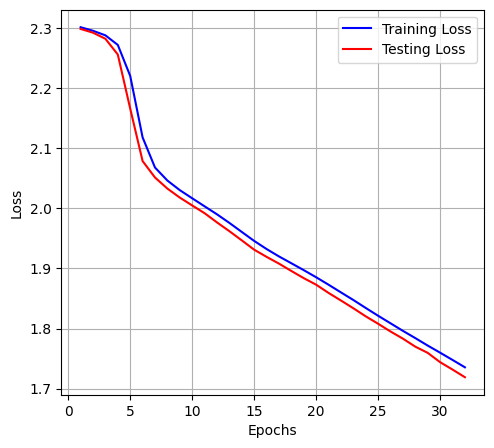

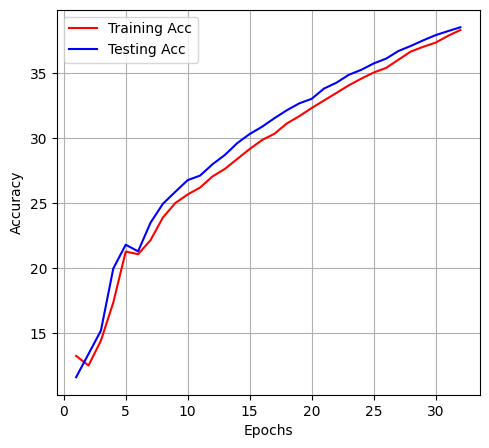

In [15]:
import matplotlib.pyplot as plt
epoch_range=range(1,1+EPOCH)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epoch_range, train_loss_history, 'b', label="Training Loss")
plt.plot(epoch_range, test_loss_history, 'r', label="Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epoch_range, train_acc_history, 'r', label="Training Acc")
plt.plot(epoch_range, test_acc_history, 'b', label="Testing Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

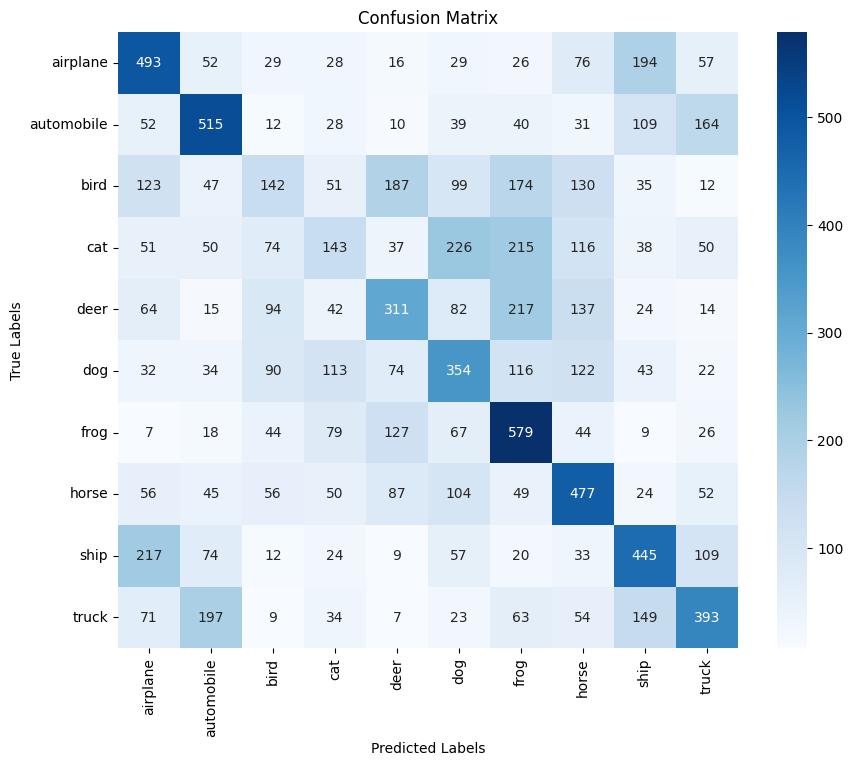

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
all_preds=[]
all_labels=[]
model.eval()
with torch.inference_mode():
    for image, label in test_dataloader:
        image, label= image.to(device), label.to(device)
        pred=model(image)
        pred_label=torch.argmax(pred, dim=1)
        all_preds.append(pred_label.cpu())
        all_labels.append(label.cpu())
        
all_preds=torch.cat(all_preds)
all_labels=torch.cat(all_labels)

cm=confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_name, yticklabels=class_name)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()